# Keras deep neural network tuned with Bayesian optmization

This notebook aims to demonstrate on training and tuning deep neural networks using Bayesian optmization. The example problem used in the notebook is a binary classification problem. We use Keras (with Tensorflow backend) as a library to develop neural network models and GPyOpt for Bayesian optmization library. In particular, the notebook performs the following.
* Create a sample binary-classification dataset that is imbalanced (ratio = 1:9)
* Split the dataset into training, test, and validation set
* Execute oversampling on the training set
* Develop example a parameterized deep learning model based on Keras Sequential model
* Focus on 5 parameters: learning rate, drop out rate, number of layers, number of hidden units, number of epoch


In [ ]:
#!/usr/bin/env python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
%matplotlib inline  
import keras

USE_RESAMPLING = True

In [46]:
from sklearn.datasets import make_classification
x_raw, y_raw = make_classification( n_samples=50000,   n_features=70,
                                    n_informative=10, n_redundant=60,
                                    random_state=42, weights={0:1.8, 1:1})

In [47]:
np.bincount(y_raw)

array([44789,  5211])

In [48]:
X_pd = pd.DataFrame(x_raw)
Y_pd = pd.DataFrame(y_raw)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pd, Y_pd, test_size=0.20,
                                                    random_state=42)

In [50]:
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=0.50, random_state=42)

In [51]:
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(5000, 70)
(5000, 1)
(5000, 70)
(5000, 1)


In [52]:
Y_test.iloc[:, 0].value_counts()

0    4468
1     532
Name: 0, dtype: int64

# Add oversampling here

In [53]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

if USE_RESAMPLING:
    target_num_samples_major = Y_train[Y_train == 1].shape[0]
    sampling_model = SMOTE()

    X_resampled_train, Y_resampled_train = sampling_model.fit_sample(X_train, Y_train)
    X_train = pd.DataFrame(X_resampled_train, columns=X_pd.columns)
    Y_train = pd.DataFrame(Y_resampled_train)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
Y_train.iloc[:,0].value_counts()

1    35877
0    35877
Name: 0, dtype: int64

In [55]:
Y_test.iloc[:,0].value_counts()

0    4468
1     532
Name: 0, dtype: int64

In [56]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(Y_train.values.reshape(-1, 1))
Y_train_encoded = enc.transform(Y_train.values.reshape(-1, 1)).toarray()
Y_test_encoded  = enc.transform(Y_test.values.reshape(-1, 1)).toarray()
Y_valid_encoded = enc.transform(Y_valid.values.reshape(-1, 1)).toarray()
Y_train_encoded

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [57]:
num_samples = X_train.shape[0]
print(num_samples)
num_features = X_train.shape[1]
print(num_features)

71754
70


In [58]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD, Adam
from sklearn.metrics import roc_auc_score

In [59]:
batch_size = 32

Evaluation function

In [60]:
def eval_results(model, X, Y):
    predict_probs = model.predict(X, batch_size=batch_size)
    Y_prob_score = predict_probs[:,1]
    
    return roc_auc_score(Y, Y_prob_score)

# Wrap the evaluation function entirely inside a function

In [92]:
def model_architecture(learning_rate, num_layers, hidden_units, dropout_rate, num_epoch):
    model = Sequential()
    for _ in range(num_layers):
        model.add(Dense(hidden_units, activation='relu', input_dim=num_features))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization(axis=-1, momentum=0.99, 
                                     epsilon=0.001, center=True, scale=True, 
                                     beta_initializer='zeros', gamma_initializer='ones'))

    # Add head at the end to be a softmax layer (Binary classification)
    model.add(Dense(2, activation='softmax'))
    adam = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    return model

In [93]:
bounds   =  [  {'name': 'learning_rate',    'type': 'continuous',  'domain': (1e-4,1e-1) },
               {'name': 'dropout_rate',     'type': 'continuous', 'domain':  (0.01, 0.25) },
               {'name': 'num_layers',       'type': 'discrete',    'domain': (5,10)},
               {'name': 'hidden_units',       'type': 'discrete',    'domain': (5,30)},
               {'name': 'num_epoch',         'type': 'discrete',    'domain':  (2,3)}]

In [94]:
def get_model_from_paras_row(paras_row, i):
    learning_rate = paras_row[0]
    dropout_rate  = paras_row[1]
    num_layers    = int(paras_row[2])
    hidden_units  = int(paras_row[3])
    num_epoch     = paras_row[4]
    
    print(""" For row %s , learning rate = %.5f, num_layers = %s, hidden_units = %s, dropout_rate = %s, num_epoch = %s    """
          % (i, learning_rate, num_layers, hidden_units, dropout_rate,  num_epoch)         
         )
    return model_architecture(learning_rate=learning_rate,
                              num_layers=num_layers,
                              hidden_units=hidden_units,
                              dropout_rate=dropout_rate,
                              num_epoch=num_epoch)

In [95]:
nfold = 2
def fit_dnn(paras2d):
    paras2d = np.atleast_2d(paras2d) # one row represents one set of parameters
    
    print(" Getting in paras2d of shape = %s" % str(paras2d.shape))
    fs = np.zeros((paras2d.shape[0],1))
    for i in range(paras2d.shape[0]):
        fs[i] = 0 # accumulator for performance metric per fold
        paras_row = paras2d[i]
        model = get_model_from_paras_row(paras_row = paras_row, i=i)
        
        num_epoch = int(paras_row[4])        
        for n in range(nfold):
            idx = np.array(range(X_train.shape[0]))
            idx_valid = np.logical_and(idx>=X_train.shape[0]/nfold*n, idx<X_train.shape[0]/nfold*(n+1))
            idx_train = np.logical_not(idx_valid)
            model.fit(X_train.values[idx_train,:], Y_train_encoded[idx_train,:], 
                      epochs=num_epoch, batch_size=batch_size, shuffle=True,
                      callbacks = None, verbose=1)
            fs[i] += eval_results(model, X_train.values[idx_valid, :], Y_train_encoded[idx_valid, 1])
        fs[i] *= 1./nfold
        
        print(" For row %s : we get the average cross validation score of %.3f: model paras = %s " % (i, fs[i], paras_row))
    return 1 - fs # We want to maximize fs (which is equivalent to minize 1 - fs
    

In [96]:
import GPyOpt # Bayesian optimization library

In [97]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_dnn,          # function to optimize       
                                          domain = bounds,          # box-constrains of the problem
                                          acquisition_type ='LCB',  # LCB acquisition
                                          acquisition_weight = 0.1) # Exploration exploitation

 Getting in paras2d of shape = (1, 5)
 For row 0 , learning rate = 0.00877, num_layers = 5, hidden_units = 5, dropout_rate = 0.063994714318, num_epoch = 2.0    
Epoch 1/2
35877/35877 [==============================] - 7s - loss: 0.2243 - acc: 0.9089     
Epoch 2/2
35877/35877 [==============================] - 4s - loss: 0.1826 - acc: 0.9221     
Epoch 1/2
35877/35877 [==============================] - 4s - loss: 0.2152 - acc: 0.9196     
Epoch 2/2
35877/35877 [==============================] - 5s - loss: 0.1615 - acc: 0.9414     
 For row 0 : we get the average cross validation score of 0.971: model paras = [ 0.00876781  0.06399471  5.          5.          2.        ] 
 Getting in paras2d of shape = (1, 5)
 For row 0 , learning rate = 0.03813, num_layers = 10, hidden_units = 5, dropout_rate = 0.204671785028, num_epoch = 3.0    
Epoch 1/3
35877/35877 [==============================] - 9s - loss: 0.3357 - acc: 0.8955     
Epoch 2/3
35877/35877 [==============================] - 7s - los

 Getting in paras2d of shape = (1, 5)
 For row 0 , learning rate = 0.00869, num_layers = 5, hidden_units = 30, dropout_rate = 0.086949033055, num_epoch = 3.0    
Epoch 1/3
35877/35877 [==============================] - 8s - loss: 0.1735 - acc: 0.9233     
Epoch 2/3
35877/35877 [==============================] - 5s - loss: 0.1282 - acc: 0.9438     
Epoch 3/3
35877/35877 [==============================] - 5s - loss: 0.1210 - acc: 0.9495     
Epoch 1/3
35877/35877 [==============================] - 6s - loss: 0.1409 - acc: 0.9529     
Epoch 2/3
35877/35877 [==============================] - 6s - loss: 0.1031 - acc: 0.9683     
Epoch 3/3
35877/35877 [==============================] - 6s - loss: 0.0894 - acc: 0.9751     
 For row 0 : we get the average cross validation score of 0.978: model paras = [  8.69498378e-03   8.69490331e-02   5.00000000e+00   3.00000000e+01
   3.00000000e+00] 
 Getting in paras2d of shape = (1, 5)
 For row 0 , learning rate = 0.02889, num_layers = 5, hidden_units =

35877/35877 [==============================] - 7s - loss: 0.1465 - acc: 0.9325     
Epoch 3/3
35877/35877 [==============================] - 6s - loss: 0.1328 - acc: 0.9418     
Epoch 1/3
35877/35877 [==============================] - 7s - loss: 0.1550 - acc: 0.9498     
Epoch 2/3
35877/35877 [==============================] - 7s - loss: 0.1284 - acc: 0.9576     
Epoch 3/3
35877/35877 [==============================] - 7s - loss: 0.1354 - acc: 0.9546     
 For row 0 : we get the average cross validation score of 0.976: model paras = [  0.03519408   0.06856786   5.          30.           3.        ] 


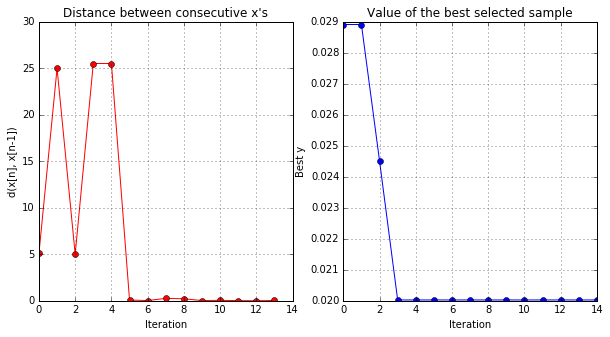

In [99]:
opt.run_optimization(max_iter=10)
opt.plot_convergence()

# Obtained parameters during the search process

Best parameter was

In [98]:
opt.x_opt

array([  1.59671076e-03,   1.83572137e-02,   5.00000000e+00,
         3.00000000e+01,   3.00000000e+00])

Best cost was (1 - AUC)

In [101]:
opt.fx_opt

array([ 0.02002737])

# Test the parameters on model

Obtained the searched parameter

In [102]:
model = get_model_from_paras_row(opt.x_opt, 0)

 For row 0 , learning rate = 0.00160, num_layers = 5, hidden_units = 30, dropout_rate = 0.0183572137312, num_epoch = 3.0    


In [103]:
num_epoch = int(opt.x_opt[4])
num_epoch

3

Trained the model for the whole training dataset

In [104]:
model.fit(X_train.values, Y_train_encoded, 
                      epochs=num_epoch, batch_size=batch_size, shuffle=True,
                      callbacks = None, verbose=1)

Epoch 1/3
71754/71754 [==============================] - 16s - loss: 0.1835 - acc: 0.9384    
Epoch 2/3
71754/71754 [==============================] - 12s - loss: 0.1371 - acc: 0.9591    
Epoch 3/3
71754/71754 [==============================] - 14s - loss: 0.1262 - acc: 0.9638    


# Test on the test set

In [106]:
eval_results(model, X_test.values, Y_test)

0.97437647666615057